# Inference on real Hyperfine data

In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *

In [2]:
def eval_hyperfine(image_path: str, model):
    image = sitk.ReadImage(image_path)
    image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image))
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0).float().cuda()
    with torch.no_grad():
        output_tensor = model(image_tensor)
    display_multiplanar_center(output_tensor[0,0].cpu().numpy())
    kl = kl_forward(model,output_tensor).cpu().detach()
    print("KL: ",kl)

## Initialization

### Load models and dataloader

In [3]:
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',100)
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',100)
brats_train_loader, brats_test_loader, brats_val_loader = get_dataloader('brats',100)

model_vae_dhcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-dhcp-1550.pth')
model_vae_hcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-hcp-last.pth')

model_vae_dhcp.eval()
model_vae_hcp.eval()

[09/05/22 01:40:58] INFO     colossalai - root - INFO: Creating dataset with 80 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 80

  0%|          | 0/80 [00:00<?, ?it/s]

[09/05/22 01:41:01] INFO     colossalai - root - INFO: Creating dataset with 20 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 20

  0%|          | 0/20 [00:00<?, ?it/s]

[09/05/22 01:41:02] INFO     colossalai - root - INFO: Creating dataset with 80 examples

  0%|          | 0/80 [00:00<?, ?it/s]

[09/05/22 01:41:03] INFO     colossalai - root - INFO: Creating dataset with 20 examples

  0%|          | 0/20 [00:00<?, ?it/s]

                    INFO     colossalai - root - INFO: Creating dataset with 80 examples

  0%|          | 0/80 [00:00<?, ?it/s]

[09/05/22 01:41:05] INFO     colossalai - root - INFO: Creating dataset with 20 examples

  0%|          | 0/20 [00:00<?, ?it/s]

BUNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(1, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
       

### Generate/Load priori

In [5]:
mu_dhcp_dhcp = []
mu_dhcp_hcp = []
mu_hcp_dhcp = []
mu_hcp_hcp = []

logvar_dhcp_dhcp = []
logvar_dhcp_hcp = []
logvar_hcp_dhcp = []
logvar_hcp_hcp = []

model_vae_dhcp.train()
model_vae_hcp.train()

for im, gt in tqdm(dhcp_val_loader):
    im = im.cuda()
    gt = gt.cuda()
    output_dhcp = model_vae_dhcp(im)
    output_hcp = model_vae_hcp(im)
    mu_dhcp_dhcp.append(model_vae_dhcp.enc_mu.cpu().detach())
    mu_hcp_dhcp.append(model_vae_hcp.enc_mu.cpu().detach())
    logvar_dhcp_dhcp.append(model_vae_dhcp.enc_logvar.cpu().detach())
    logvar_hcp_dhcp.append(model_vae_hcp.enc_logvar.cpu().detach())
for im, gt in tqdm(hcp_val_loader):
    im = im.cuda()
    gt = gt.cuda()
    output_dhcp = model_vae_dhcp(im)
    output_hcp = model_vae_hcp(im)
    model_vae_dhcp.VAE_loss(output_dhcp,gt)
    model_vae_hcp.VAE_loss(output_hcp,gt)
    mu_dhcp_hcp.append(model_vae_dhcp.enc_mu.cpu().detach())
    mu_hcp_hcp.append(model_vae_hcp.enc_mu.cpu().detach())
    logvar_dhcp_hcp.append(model_vae_dhcp.enc_logvar.cpu().detach())
    logvar_hcp_hcp.append(model_vae_hcp.enc_logvar.cpu().detach())



# mu_dhcp_dhcp = torch.stack(mu_dhcp_dhcp).cpu().numpy().mean(axis=1)
# mu_dhcp_hcp = torch.stack(mu_dhcp_hcp).cpu().numpy().mean(axis=1)
# mu_dhcp_brats = torch.stack(mu_dhcp_brats).cpu().numpy().mean(axis=1)
# mu_hcp_dhcp = torch.stack(mu_hcp_dhcp).cpu().numpy().mean(axis=1)
# mu_hcp_hcp = torch.stack(mu_hcp_hcp).cpu().numpy().mean(axis=1)
# mu_hcp_brats = torch.stack(mu_hcp_brats).cpu().numpy().mean(axis=1)

# logvar_dhcp_dhcp = torch.stack(logvar_dhcp_dhcp).cpu().numpy().mean(axis=1)
# logvar_dhcp_hcp = torch.stack(logvar_dhcp_hcp).cpu().numpy().mean(axis=1)
# logvar_dhcp_brats = torch.stack(logvar_dhcp_brats).cpu().numpy().mean(axis=1)
# logvar_hcp_dhcp = torch.stack(logvar_hcp_dhcp).cpu().numpy().mean(axis=1)
# logvar_hcp_hcp = torch.stack(logvar_hcp_hcp).cpu().numpy().mean(axis=1)
# logvar_hcp_brats = torch.stack(logvar_hcp_brats).cpu().numpy().mean(axis=1)


mu_dhcp_dhcp = torch.stack(mu_dhcp_dhcp)
mu_dhcp_hcp = torch.stack(mu_dhcp_hcp)
mu_hcp_dhcp = torch.stack(mu_hcp_dhcp)
mu_hcp_hcp = torch.stack(mu_hcp_hcp)

logvar_dhcp_dhcp = torch.stack(logvar_dhcp_dhcp)
logvar_dhcp_hcp = torch.stack(logvar_dhcp_hcp)
logvar_hcp_dhcp = torch.stack(logvar_hcp_dhcp)
logvar_hcp_hcp = torch.stack(logvar_hcp_hcp)

torch.save(mu_dhcp_dhcp, '/media/hdd/viscent/SR-UNet/results/mu_dhcp_dhcp.pt')
torch.save(mu_dhcp_hcp, '/media/hdd/viscent/SR-UNet/results/mu_dhcp_hcp.pt')
torch.save(mu_hcp_dhcp, '/media/hdd/viscent/SR-UNet/results/mu_hcp_dhcp.pt')
torch.save(mu_hcp_hcp, '/media/hdd/viscent/SR-UNet/results/mu_hcp_hcp.pt')

torch.save(logvar_dhcp_dhcp, '/media/hdd/viscent/SR-UNet/results/logvar_dhcp_dhcp.pt')
torch.save(logvar_dhcp_hcp, '/media/hdd/viscent/SR-UNet/results/logvar_dhcp_hcp.pt')
torch.save(logvar_hcp_dhcp, '/media/hdd/viscent/SR-UNet/results/logvar_hcp_dhcp.pt')
torch.save(logvar_hcp_hcp, '/media/hdd/viscent/SR-UNet/results/logvar_hcp_hcp.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
mu_dhcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_dhcp_dhcp.pt')
mu_dhcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_dhcp_hcp.pt')
mu_hcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_hcp_dhcp.pt')
mu_hcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_hcp_hcp.pt')

logvar_dhcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_dhcp_dhcp.pt')
logvar_dhcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_dhcp_hcp.pt')
logvar_hcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_hcp_dhcp.pt')
logvar_hcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_hcp_hcp.pt')

In [29]:
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220706/vae_hcp/160.pth')
model_vae_hcp.augmentation = False
model_vae_hcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-hcp-last.pth')

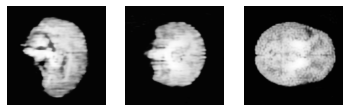

KL:  tensor(2208294.5000)


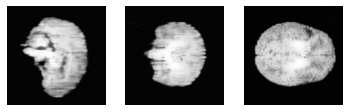

KL:  tensor(2208287.5000)


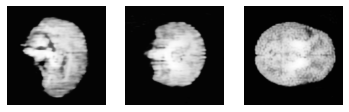

KL:  tensor(2208280.5000)


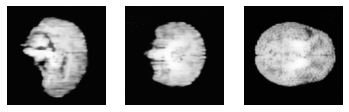

KL:  tensor(2208323.5000)


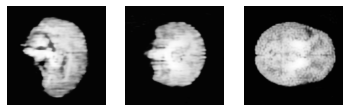

KL:  tensor(2208287.7500)


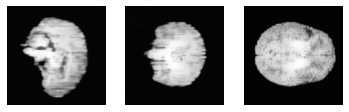

KL:  tensor(2208334.)


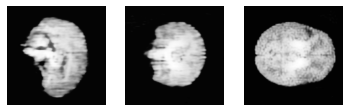

KL:  tensor(2208243.)


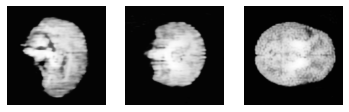

KL:  tensor(2208282.)


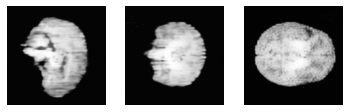

KL:  tensor(2208308.5000)


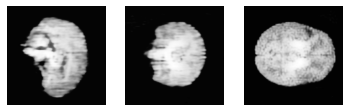

KL:  tensor(2208336.)


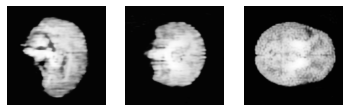

KL:  tensor(2208258.7500)


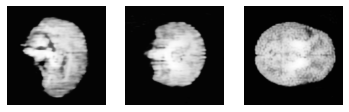

KL:  tensor(2208316.)


In [5]:
from glob import glob
inputs = glob('/media/hdd/viscent/inference_hyperfine/Brown/input/*.nii.gz')
for input in inputs:
    eval_hyperfine('/media/hdd/viscent/SR-UNet/inference/Input_HCP.nii.gz',model_vae_hcp)